# Recommender System 
Shubham Soni - 9916102118 || 
Naman Sahni - 9916102170 || 
Swapnil Srivastav - 9916102200

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# movies dataset
movies_df = pd.read_csv('ml-1m/movies.dat', sep='::', header=None, engine='python')
movies_df.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# ratings dataset
ratings_df = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None, engine='python')
ratings_df.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
movies_df.columns = ['MovieID', 'Title', 'Genres']
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
print('The Number of Movies in Dataset', len(movies_df))

The Number of Movies in Dataset 3883


In [7]:
movies_df['List Index'] = movies_df.index
movies_df.head()
merged_df = movies_df.merge(ratings_df, on='MovieID')

In [8]:
# Drop unnecessary columns
merged_df = merged_df.drop('Timestamp', axis=1).drop('Title', axis=1).drop('Genres', axis=1)

# Display the result
merged_df.head()

,MovieID,List Index,UserID,Rating
0,1,0,1,5
1,1,0,6,4
2,1,0,8,4
3,1,0,9,5
4,1,0,10,5


In [9]:
# Group the Users by their user ID's
user_Group = merged_df.groupby('UserID')
user_Group.head()

,MovieID,List Index,UserID,Rating
0,1,0,1,5
1,1,0,6,4
2,1,0,8,4
3,1,0,9,5
4,1,0,10,5
...,...,...,...,...
874890,3285,3216,1270,1
883271,3357,3288,4896,5
903916,3448,3379,4025,5
928813,3548,3479,986,3


#### Formatting the data into input for the RBM. 
#### Storing the normalized users ratings into a list of lists called trX.

In [10]:
# Amount of users used for training
amountOfUsedUsers = 1000

# Creating the training list
trX = []

# For each user in the group
for userID, curUser in user_Group:

    # Create a temp that stores every movie's rating
    temp = [0]*len(movies_df)

    # For each movie in curUser's movie list
    for num, movie in curUser.iterrows():

        # Divide the rating by 5 and store it
        temp[movie['List Index']] = movie['Rating']/5.0

    # Add the list of ratings into the training list
    trX.append(temp)

    # Check to see if we finished adding in the amount of users for training
    if amountOfUsedUsers == 0:
        break
    amountOfUsedUsers -= 1
print(trX)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Setting the model parameters

In [11]:
hiddenUnits = 50
visibleUnits = len(movies_df)
vb = tf.placeholder(tf.float32, [visibleUnits])  # Number of unique movies
hb = tf.placeholder(tf.float32, [hiddenUnits])  # Number of features were going to learn
W = tf.placeholder(tf.float32, [visibleUnits, hiddenUnits])  # Weight Matrix


In [12]:
# Phase 1: Input Processing
v0 = tf.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)  # Visible layer activation
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))  # Gibb's Sampling

# Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)  # Hidden layer activation
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

Setting RBM Training Parameters

In [13]:
# Learning rate
alpha = 1.0

# Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

# Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

# Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

Instructions for updating:
Use `tf.cast` instead.


In [14]:
# Setting the error function (Mean Absolute Error)
err = v0 - v1
err_sum = tf.reduce_mean(err*err)

Initializing our Variables with Zeroes

In [15]:
# Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

# Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)

# Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)

# Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

# Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)

# Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())


Training RBM with 15 Epochs, with Each Epoch using 10 batches with size 100, After training print out the error by epoch

0.12231472
0.082050316
0.06782164
0.060230155
0.05543284
0.052229244
0.04911029
0.046600677
0.04484626
0.043896347
0.042968456
0.042380378
0.041647244
0.041137736
0.040685035


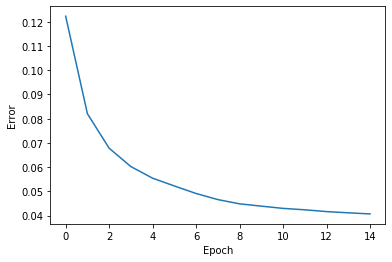

In [16]:
epochs = 15
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip(range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print(errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

# Recommendation

In [17]:
# Select the input User
inputUser = [trX[50]]

In [18]:
# Feeding in the User and Reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb: prv_vb})

In [19]:
# Listing the 20 most recommended movies for our mock user by sorting it 
# by their scores given by our model.
scored_movies_df_50 = movies_df
scored_movies_df_50["Recommendation Score"] = rec[0]
scored_movies_df_50.sort_values(["Recommendation Score"], ascending=False).head(20)


,MovieID,Title,Genres,List Index,Recommendation Score
2789,2858,American Beauty (1999),Comedy|Drama,2789,0.724314
3091,3160,Magnolia (1999),Drama,3091,0.461902
2928,2997,Being John Malkovich (1999),Comedy,2928,0.449446
1959,2028,Saving Private Ryan (1998),Action|Drama|War,1959,0.425853
1575,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,1575,0.374624
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,589,0.372671
2693,2762,"Sixth Sense, The (1999)",Thriller,2693,0.368873
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,1192,0.366038
2530,2599,Election (1999),Comedy,2530,0.360337
523,527,Schindler's List (1993),Drama|War,523,0.351140


Recommending User what movies he has not watched yet

In [20]:
# Find the mock user's UserID from the data
print(merged_df.iloc[50])  # Result you get is UserID 150

# Find all movies the mock user has watched before
movies_df_50 = merged_df[merged_df['UserID'] == 150]
movies_df_50.head()

MovieID         1
List Index      0
UserID        150
Rating          4
Name: 50, dtype: int64


,MovieID,List Index,UserID,Rating
50,1,0,150,4
11866,24,23,150,4
12492,25,24,150,4
15967,34,33,150,5
36528,111,109,150,4


Merge all movies that our mock users has watched with predicted scores based on his historical data:

In [21]:
# Merging movies_df with ratings_df by MovieID
merged_df_50 = scored_movies_df_50.merge(movies_df_50, on='MovieID', how='outer')

# Dropping unnecessary columns
merged_df_50 = merged_df_50.drop('List Index_y', axis=1).drop('UserID', axis=1)

# Sort and take a look at first 20 rows
merged_df_50.sort_values(['Recommendation Score'], ascending=False).head(20)

,MovieID,Title,Genres,List Index_x,Recommendation Score,Rating
2789,2858,American Beauty (1999),Comedy|Drama,2789,0.724314,5.0
3091,3160,Magnolia (1999),Drama,3091,0.461902,3.0
2928,2997,Being John Malkovich (1999),Comedy,2928,0.449446,4.0
1959,2028,Saving Private Ryan (1998),Action|Drama|War,1959,0.425853,5.0
1575,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,1575,0.374624,4.0
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,589,0.372671,5.0
2693,2762,"Sixth Sense, The (1999)",Thriller,2693,0.368873,4.0
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,1192,0.366038,3.0
2530,2599,Election (1999),Comedy,2530,0.360337,3.0
523,527,Schindler's List (1993),Drama|War,523,0.351140,4.0



There are some movies the user has not watched and has high score based on our model. So, we can recommend them.